In [1]:
import os
import numpy as np
import pandas as pd
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
!pip install split-folders
import splitfolders
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import Sequential
from keras.layers import Dense, MaxPooling2D, Conv2D, Flatten, BatchNormalization, Dropout
from tensorflow.keras.preprocessing import image

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/.

In [3]:
!kaggle datasets download -d omkargurav/face-mask-dataset

face-mask-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
import zipfile
zip = zipfile.ZipFile('/content/face-mask-dataset.zip', 'r')
zip.extractall('/content')
zip.close()

In [5]:
face_withmask = os.listdir('/content/data/with_mask')
face_withoutmask = os.listdir('/content/data/without_mask')

print(f'number of with mask img: {len(face_withmask)}')
print(f'number of with out mask img: {len(face_withoutmask)}')

number of with mask img: 3725
number of with out mask img: 3828


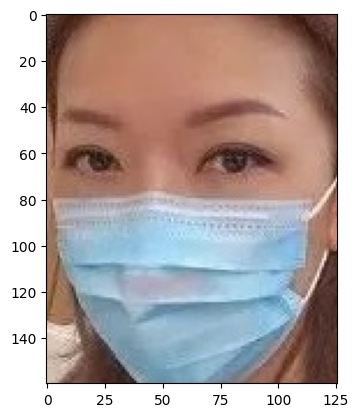

In [6]:
# Image With Mask

img_withmask = cv2.imread('/content/data/with_mask/with_mask_105.jpg')
clr=cv2.cvtColor(img_withmask, cv2.COLOR_BGR2RGB)
plt.imshow(clr);


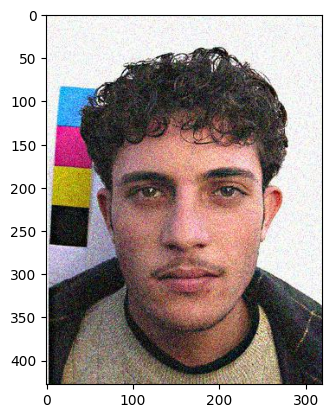

In [7]:
# Image Without Mask

img_withoutmask = cv2.imread('/content/data/without_mask/without_mask_1163.jpg')
clr = cv2.cvtColor(img_withoutmask, cv2.COLOR_BGR2RGB)
plt.imshow(clr);

In [8]:
dir = '/content/data'
splitfolders.ratio(dir, output='splitted_data', seed=22, ratio=(0.85, 0.15))

Copying files: 7553 files [00:02, 3340.57 files/s]


In [9]:
train_dir = '/content/splitted_data/train'
test_dir = '/content/splitted_data/val'


train_ds = keras.utils.image_dataset_from_directory(directory = train_dir,
                                                    labels = 'inferred',
                                                    label_mode = 'binary',
                                                    batch_size = 32,
                                                    image_size = (250,250))

validation_ds = keras.utils.image_dataset_from_directory(directory = test_dir,
                                                    labels = 'inferred',
                                                    label_mode = 'binary',
                                                    batch_size = 32,
                                                    image_size = (250,250))

Found 6419 files belonging to 2 classes.
Found 1134 files belonging to 2 classes.


In [10]:
train_ds.class_names

['with_mask', 'without_mask']

In [11]:
def process(image,label):
  image = tf.cast(image/255. ,tf.float32)
  return image,label

train_ds = train_ds.map(process)
validation_ds = validation_ds.map(process)

In [12]:
data_augumentation = keras.Sequential([layers.experimental.preprocessing.RandomFlip('horizontal', input_shape=(250,250,3)),
                                       layers.experimental.preprocessing.RandomRotation(0.1),
                                       layers.experimental.preprocessing.RandomZoom(0.2)])

In [13]:
model = Sequential()

model.add(data_augumentation)

model.add(Conv2D(65, kernel_size=(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='same'))

model.add(Conv2D(130, kernel_size=(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='same'))

model.add(Flatten())

model.add(Dense(140, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(70, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))


model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [15]:
history = model.fit(train_ds, epochs=10, validation_data=validation_ds)

Epoch 1/10
201/201 [==============================] - 57s 213ms/step - loss: 11.5266 - accuracy: 0.8051 - val_loss: 20.0497 - val_accuracy: 0.5970
Epoch 2/10
201/201 [==============================] - 38s 189ms/step - loss: 3.1252 - accuracy: 0.8258 - val_loss: 14.6619 - val_accuracy: 0.7381
Epoch 3/10
201/201 [==============================] - 39s 193ms/step - loss: 0.7735 - accuracy: 0.8439 - val_loss: 0.7219 - val_accuracy: 0.8871
Epoch 4/10
201/201 [==============================] - 38s 188ms/step - loss: 0.4588 - accuracy: 0.8621 - val_loss: 0.3871 - val_accuracy: 0.8616
Epoch 5/10
201/201 [==============================] - 38s 190ms/step - loss: 0.3899 - accuracy: 0.8651 - val_loss: 0.3209 - val_accuracy: 0.8589
Epoch 6/10
201/201 [==============================] - 38s 189ms/step - loss: 0.3114 - accuracy: 0.8796 - val_loss: 0.3486 - val_accuracy: 0.8713
Epoch 7/10
201/201 [==============================] - 38s 188ms/step - loss: 0.3007 - accuracy: 0.8888 - val_loss: 0.3251 - val

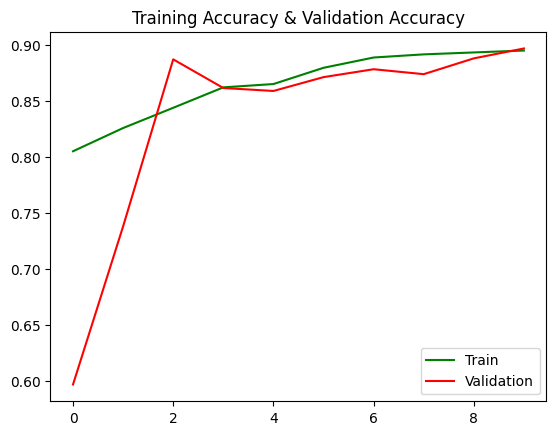

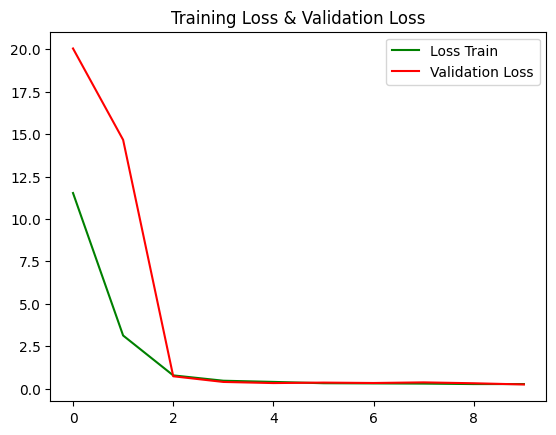

In [16]:
h = history

# Accuracy Plot

plt.plot(h.history['accuracy'], color='green', label='Train')
plt.plot(h.history['val_accuracy'], color='red', label='Validation')
plt.title('Training Accuracy & Validation Accuracy')
plt.legend()
plt.show();

# Loss Plot

plt.plot(h.history['loss'], color='green', label='Loss Train')
plt.plot(h.history['val_loss'], color='red', label='Validation Loss')
plt.title('Training Loss & Validation Loss')
plt.legend()
plt.show();

In [19]:
def predict_image(img_path):
  img = image.load_img(img_path,target_size = (250,250))
  img_array = image.img_to_array(img)
  img_batch = np.expand_dims(img_array,axis = 0)
  result = model.predict(img_batch)

  if result>=0.5:
    return("The Person is Not Wearing the Mask - [NO MASK]")
  else:
    return("The Person is Wearing the Mask - [MASK CONFIRM]")

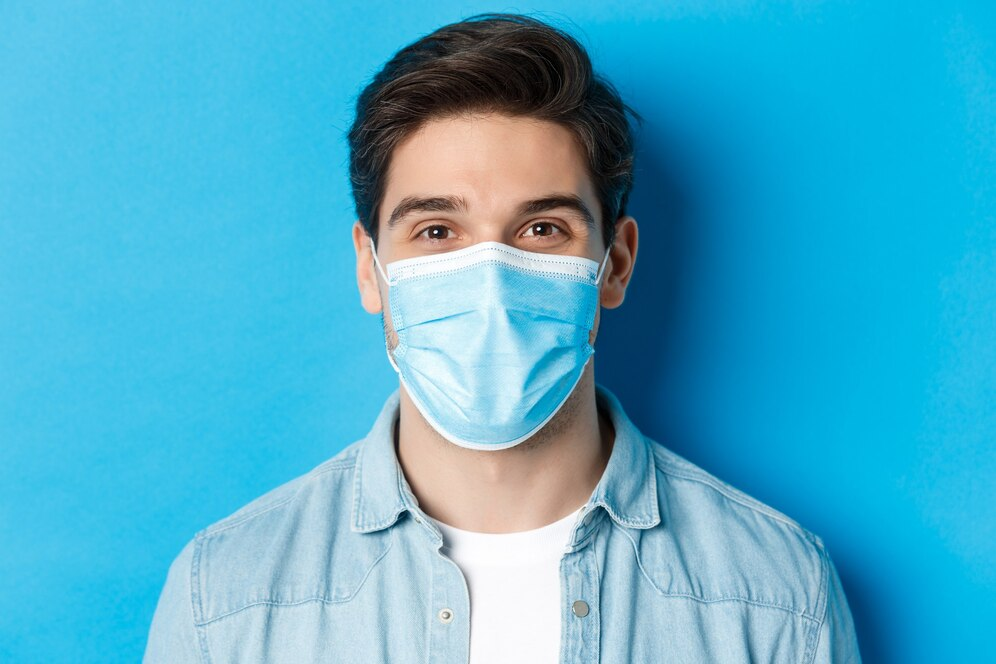

1/1 [==============================] - 0s 219ms/step


'The Person is Wearing the Mask - [MASK CONFIRMED]'

In [20]:
t1 = cv2.imread('/content/with a mask.jpg')
cv2_imshow(t1)

predict_image('/content/with a mask.jpg')

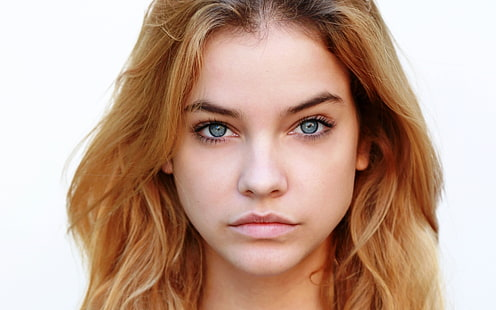

1/1 [==============================] - 0s 18ms/step


'The Person is Not Wearing the Mask - [NO MASK]'

In [21]:
t2 = cv2.imread('/content/with out mask.jpg')
cv2_imshow(t2)

predict_image('/content/with out mask.jpg')

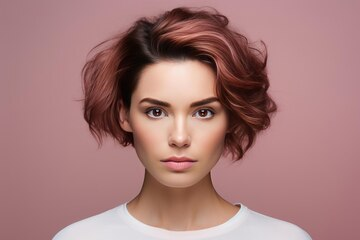

1/1 [==============================] - 0s 40ms/step


'The Person is Not Wearing the Mask - [NO MASK]'

In [22]:
t3 = cv2.imread('/content/woman-hair-salon-beauty-concept-ai-generated_201606-12647.jpg')
cv2_imshow(t3)

predict_image('/content/woman-hair-salon-beauty-concept-ai-generated_201606-12647.jpg')

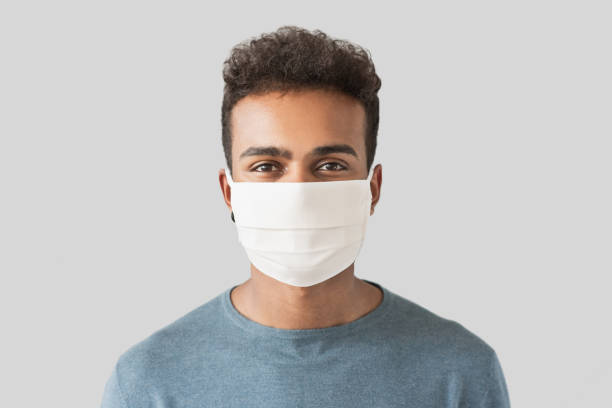

1/1 [==============================] - 0s 19ms/step


'The Person is Wearing the Mask - [MASK CONFIRMED]'

In [23]:
t5 = cv2.imread('/content/istockphoto-1272058180-612x612.jpg')
cv2_imshow(t5)

predict_image('/content/istockphoto-1272058180-612x612.jpg')